![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

## Small disks and geometric facility location: *a mixed integer conic quadratic tutorial*
In this tutorial we are going to:
* show examples of compact models constructed with *Fusion*,
* write a conic model with binary variables,
* apply the *Big-M* formulation,
* construct a base model and use its various extensions to solve a number of different problems.

### Introduction

We are going to work with variations of the following geometric setup. Suppose we have $n$ of points $p_1,\ldots,p_n\in\mathbb{R}^d$ and we want to find a configuration of $k$ balls with centers $x_1,\ldots,x_k\in\mathbb{R}^d$ and radii $r_1,\ldots,r_k$, respectively, which covers some/all of the points $p_i$ and satisfies additional constraints depending on the problem. For visualization purposes we will focus on the plane and disks, that is the case $d=2$, but the code and mathematical formulation remain valid in all dimensions.

For example, the next snippet displays a set of points in $\mathbb{R}^2$. Here is a sample question: how many of those points can we cover with three disks of radius at most $0.1$ each?


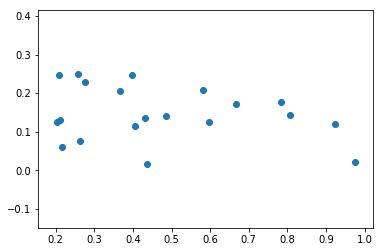

In [1]:
%matplotlib inline
from mosek.fusion import *
import mosek.fusion.pythonic
import numpy as np

def data(n):
    np.random.seed(1236)
    return [[x,y] for x,y in np.broadcast(np.random.uniform(0.0, 1.0, n), np.random.uniform(0.0, 0.3, n))]
def gaussianData(n):
    np.random.seed(1236)
    return [[x,y] for x,y in np.broadcast(np.random.normal(0.0, 1.0, n), np.random.normal(0.0, 1.0, n))]

def display(P, R, X):
	import matplotlib.pyplot as plt
	plt.scatter(*zip(*P))
	plt.axis("equal")
	for i in range(len(R)):
		plt.gcf().gca().add_artist( plt.Circle((X[2*i],X[2*i+1]), R[i], fc="r", color="r", alpha=0.5) )
		plt.gcf().gca().plot(X[2*i],X[2*i+1], "or")
	plt.show()

display(data(20), [], [])

### A base model formulation in *Fusion*

Our input is a collection of points $p_1\ldots,p_n\in\mathbb{R}^d$ and an integer $k\geq 1$. What we want to compute is the centers $x_1,\ldots,x_k\in\mathbb{R}^d$ and the radii $r_1,\ldots,r_k\geq 0$ of $k$ balls $B_d(x_j;r_j)$, subject to various constraints on how the points and balls interact. The basic notion we need to model is that of which points are covered by which balls. To this end we introduce standard binary variables

\begin{equation}
s_{ij} = \left\lbrace
   \begin{array}{cl}
   1 & \text{if the ball } B_d(x_j;r_j) \text{ covers the point } p_i, \\
   0 & \text{otherwise}.
   \end{array}\right.
\end{equation}

For this to work we must ensure the implication

\begin{equation}
s_{ij}=1 \implies r_j\geq \lVert p_i-x_j \rVert_2.
\end{equation}

This can be achieved by introducing a constraint

\begin{equation}
r_j\geq \lVert p_i-x_j \rVert_2 - M(1-s_{ij})
\end{equation}

where $M$, also known as *Big-M*, is large enough to guarantee that when $s_{ij}=0$ the corresponding constraint is trivially satisfied, for example the right-hand side is surely negative. The spread of the data points $p_i$ determines a safe value of $M$ for us:


In [2]:
def bigM(P):
    return 2*np.shape(P)[1]*max(np.amax(P,0)-np.amin(P,0))

Finally we get a family of conic constraints

\begin{equation}
(r_j + M(1-s_{ij}),\  p_i-x_j) \in \mathcal{Q}^{d+1}, \quad i=1,\ldots,n,\ j=1,\ldots,k
\end{equation}

and its direct implementation in *Fusion*:

In [3]:
def basicModel(k, P, bigM):
    n, dim = len(P), len(P[0])                              #in P each row is one p_i
    M = Model("balls")
    R = M.variable(k, Domain.greaterThan(0.0))              #r_1...r_k
    X = M.variable([k,dim], Domain.unbounded())             #each row is one x_j
    S = M.variable([n,k], Domain.binary())
   
    RRep = Var.repeat(R, n)
    Penalty = Expr.flatten(bigM * (1.0 - S))                #M*(1-S)
    CoordDiff = np.repeat(P,k,0) - Var.repeat(X, n)         #each p_i meet each x_j once in Expr.sub
  
    M.constraint(Expr.hstack(RRep + Penalty, CoordDiff), Domain.inQCone())

    return M, R, X, S

We can now take this as a base and solve a number of different optimization problems.

### Problem 1. Minimal enclosing ball

**Objective: find the smallest ball containing all of the points.** 

This is a classical problem, see the [bounding sphere](https://en.wikipedia.org/wiki/Bounding_sphere) and [smallest-circle problem](https://en.wikipedia.org/wiki/Smallest-circle_problem) Wikipedia articles. There is an algorithm with running time $O(n)$ in any fixed dimension, and also MOSEK can solve it efficiently for a large number of points.

Since we want to include all points, the Big-M constant and the $s_{ij}$ indicators are superfluous. All we want to do is to set $k=1$ and minimize the radius of the single ball in the model.

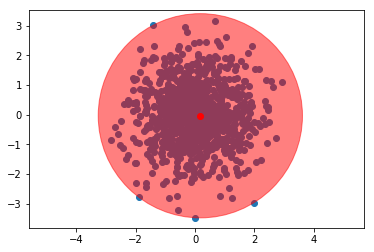

CPU times: user 596 ms, sys: 96 ms, total: 692 ms
Wall time: 507 ms


In [4]:
def minimalEnclosing(P):
    M, R, X, S = basicModel(1, P, 0.0)
    M.constraint(S == 1.0)
    M.objective(ObjectiveSense.Minimize, R[0])
    M.writeTask('p1.task.gz')
    M.solve()
    return R.level(), X.level()

P = gaussianData(1000)
r, x = minimalEnclosing(P)
display(P, r, x)

### Problem 2. Maximum coverage

**Objective: find the largest subset which can be covered by a ball of fixed radius.** 

This is also a well-known and multi-facet problem, see [this paper](http://www.cs.princeton.edu/~chazelle/pubs/CirclePlacement.pdf) by Chazelle and Evanston. It can be interpreted as selecting a location for a single fixed-power transmitter so that the signal reaches as many locations as possible. In the combinatorial setting it is equivalent to finding maximal cliques in unit-disk graphs. The best known algorithms for this problem achieve running time $O(n^2\log{n})$. 

In this setup we still operate with $k=1$ and we bound the radius from above. Each $s_i=s_{i1}$ determines if the $i$-th point is covered, with the optimization objective equal to $\sum s_{i}$.

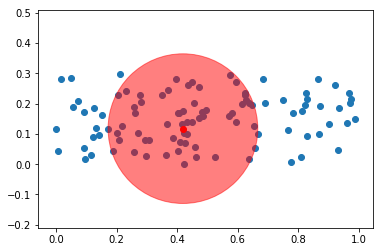

CPU times: user 1min 2s, sys: 19.3 s, total: 1min 22s
Wall time: 5.55 s


In [5]:
def maxCoverage(P, rMax):
    M, R, X, S = basicModel(1, P, bigM(P))
    M.constraint(R <= rMax)
    M.objective(ObjectiveSense.Maximize, Expr.sum(S))
    M.writeTask('p2.task.gz')
    M.solve()
    return R.level(), X.level()

P = data(100)
r, x = maxCoverage(P, 0.25)
display(P, r, x)

### Problem 3. Smallest diameter k-circle cover

**Objective: find $k$ circles which together cover all the points and have the smallest sum of diameters.**

This is a different geometric facility location problem, where we want to serve the whole population with $k$ transmitters while minimizing their total range. See the paper [Minimum-Cost Coverage of Point Sets by Disks](http://jeffe.cs.illinois.edu/pubs/pdf/carrots.pdf) for more details. It can also be seen as a form of clustering witk $k$ clusters.

The objective here is of course to minimize $\sum r_j$. A point $p_i$ is covered if $\max_j s_{ij}=1$, a condition we can linearize as: 

$$\sum_j s_{ij}\geq 1,\ \forall i=1,\ldots,n.$$

For $k=1$ we recover as a special case the minimal enclosing ball problem. It is quite frequent that certain locations are served by their own transmitter with range $r_j\approx 0$.

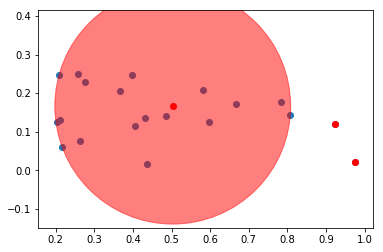

CPU times: user 1min 18s, sys: 30.8 s, total: 1min 49s
Wall time: 4.23 s


In [6]:
def minDiamKCircleCover(P, k):
    M, R, X, S = basicModel(k, P, bigM(P))
    M.constraint(Expr.sum(S,1) >= 1.0)                 #sum inside each row, i.e. along dimension 1
    M.objective(ObjectiveSense.Minimize, Expr.sum(R))
    M.writeTask('p3.task.gz')
    M.solve()
    return R.level(), X.level()

P = data(20)
r, x = minDiamKCircleCover(P, 3)
display(P, r, x)

### Problem 4. Smallest area k-circle cover

**Objective: find $k$ circles which together cover all the points and have the smallest sum of areas.**

Here we have another version of the previous problem where the cost of a network is measured (roughly, up to intersections of balls) by the total area it covers, so the $\ell_2$ norm replaces the $\ell_1$ norm of the radii vector. As pointed out in [here](http://jeffe.cs.illinois.edu/pubs/pdf/carrots.pdf) the most realistic models of wireless transmission actually optimize for the $\ell_p$ norm with some $p>2$. 

This problem is similar to the previous one, but with a different objective: we minimize $\sqrt{\sum_j r_j^2}$. This is expressed using a conic constraint. Optimizing the $\ell_2$ norm results in a more balanced collection of balls, as we can see below for the same dataset as in Problem 3.

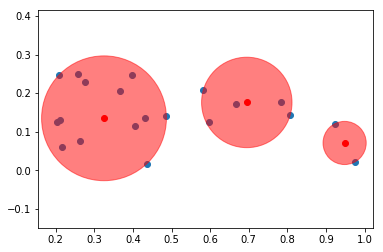

CPU times: user 47.7 s, sys: 20 s, total: 1min 7s
Wall time: 2.71 s


In [7]:
def minAreaKCircleCover(P, k):
    M, R, X, S = basicModel(k, P, bigM(P))
    t = M.variable(1, Domain.greaterThan(0.0))             
    M.constraint(Expr.vstack(t, R), Domain.inQCone())        #t>=sqrt(sum r_i^2)
    M.constraint(Expr.sum(S,1) >= 1.0)
    M.objective(ObjectiveSense.Minimize, t)
    M.writeTask('p4.task.gz')
    M.solve()
    return R.level(), X.level()

P = data(20)
r, x = minAreaKCircleCover(P, 3)
display(P, r, x)

### Problem 5. Maximum k-coverage

**Objective: find the largest subset which can be covered by $k$ balls of a fixed radius.**

We can combine the previous techniques to express more complicated problems, like covering the largest possible number of points with $k$ fixed-power transmitters. Here we want to maximize $\sum_i\max_j{s_{ij}}$, which is precisely the number of covered points, and we want to have an upper bound on $r_j$. The objective is equivalent to:

$$\max\sum_i t_i \quad \textrm{subject to}\quad t_i\in\{0,1\},\ \ t_i \leq \sum_js_{ij}.$$

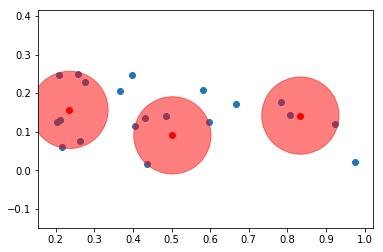

CPU times: user 3min 40s, sys: 1min 43s, total: 5min 23s
Wall time: 10.7 s


In [8]:
def maxKCoverage(P, k, rMax):
    M, R, X, S = basicModel(k, P, bigM(P))
    M.constraint(R == rMax)
    t = M.variable("t", len(P), Domain.binary())
    M.constraint(t <= Expr.sum(S,1))                     #contains one inequality for each column
    M.objective(ObjectiveSense.Maximize, Expr.sum(t))
    M.setSolverParam('mioConicOuterApproximation', 'on')
    M.writeTask('p5.task.gz')
    M.solve()
    return R.level(), X.level()

P = data(20)
r, x = maxKCoverage(P, 3, 0.1)
display(P, r, x)

### Comments

For simplicity of the presentation we ignored various issues and hints and we leave them as an exercise:
* Checking that a solution has actually been found.
* More generally: handling exceptions.
* For large instances one should perhaps terminate the solver when a solution of sufficiently high quality has been located.



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 

